<a href="https://colab.research.google.com/github/johnyu1234/Food_Classification/blob/main/FoodClassification_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
import _pickle as pickle
from keras.utils import np_utils
import numpy as np
import glob
import random
!rm -rf dataset
!git clone https://github.com/johnyu1234/dataset.git

Cloning into 'dataset'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 7263 (delta 8), reused 90 (delta 5), pack-reused 7166
Receiving objects: 100% (7263/7263), 407.68 MiB | 47.14 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Checking out files: 100% (7226/7226), done.


# New Section

In [2]:
!pip install efficientnet

     |████████████████████████████████| 51kB 4.4MB/s 


In [3]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    directory=r"./dataset/train/",
    target_size=(112, 112),
    color_mode="rgb",
    batch_size=6,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset="training"
)
validation_generator = train_datagen.flow_from_directory(
   directory=r"./dataset/train/",
    target_size=(112, 112),
    color_mode="rgb",
    batch_size=6,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset='validation') # set as validation data
test_generator = train_datagen.flow_from_directory(
    directory=r"./dataset/test/",
    target_size=(112, 112),
    color_mode="rgb",
    batch_size=6,
    class_mode="categorical",
    seed=42,
    shuffle=False
)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels_test = (test_generator.class_indices)
labels_test = dict((v,k) for k,v in labels_test.items())
print(validation_generator.classes[1])
print(validation_generator.filenames[1])
print(labels)
print(labels_test)

Found 5035 images belonging to 10 classes.
Found 1254 images belonging to 10 classes.
Found 937 images belonging to 10 classes.
0
apple_pie/1011328.jpg
{0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'banana', 4: 'instant_noodle', 5: 'miso_soup', 6: 'omelette', 7: 'rice', 8: 'spring_rolls', 9: 'tiramisu'}
{0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'banana', 4: 'instant_noodle', 5: 'miso_soup', 6: 'omelette', 7: 'rice', 8: 'spring_rolls', 9: 'tiramisu'}


In [4]:
import numpy 
import efficientnet.keras as efn 
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Flatten,Dropout ,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
#standardizes the inputs to a layer for each mini-batch. 
#This has the effect of stabilizing the learning process 
#and dramatically reducing the number of training epochs required to train deep networks
model = Sequential()
#model.add(VGG16(weights='imagenet', include_top=False,classes = 4,input_shape=(224,224,3)))
model.add(efn.EfficientNetB7(include_top=False, weights="imagenet", classes=10,input_shape=(112,112,3)))
model.add(GlobalAveragePooling2D())
#model.add(Flatten())
model.add(Dense(8192, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# causes accuracy loss at epoch 19-20 after adding another Dense and Dropout
#model.add(Dense(2048, activation='relu'))
#model.add(Dropout(0.2))


model.add(Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

258441216/258434480 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 4, 4, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 8192)              20979712  
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_______________________________________________________

In [5]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
hist = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)
# training accuracy might be low due to dropout function

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
839/839 [==============================] - 197s 196ms/step - loss: 2.3137 - accuracy: 0.2846 - val_loss: 1.2209 - val_accuracy: 0.5742
Epoch 2/20
839/839 [==============================] - 161s 192ms/step - loss: 1.5011 - accuracy: 0.5083 - val_loss: 0.9061 - val_accuracy: 0.6930
Epoch 3/20
839/839 [==============================] - 161s 192ms/step - loss: 1.1772 - accuracy: 0.6079 - val_loss: 0.7136 - val_accuracy: 0.7759
Epoch 4/20
839/839 [==============================] - 161s 192ms/step - loss: 1.0355 - accuracy: 0.6587 - val_loss: 0.6669 - val_accuracy: 0.7847
Epoch 5/20
839/839 [==============================] - 161s 192ms/step - loss: 0.9145 - accuracy: 0.7027 - val_loss: 0.6645 - val_accuracy: 0.7831
Epoch 6/20
839/839 [==============================] - 161s 192ms/step - loss: 0.7824 - accuracy: 0.7284 - val_loss: 0.6498 - val_accuracy: 0.8070
Epoch 7/20
839/839 [==============================] - 161s 192ms/step - loss: 0.7738 - accuracy: 0.7380 - val_loss: 0.5530 -

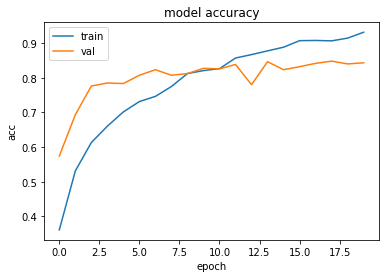

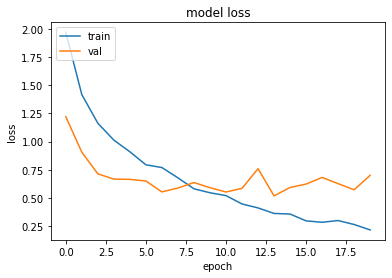

In [6]:
import matplotlib.pyplot as plt


plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
from keras.models import load_model


from google.colab import drive
drive.mount('/content/gdrive')
model.save("/content/gdrive/My Drive/effnb7_dropout_best.h5")

Mounted at /content/gdrive


In [8]:
score, acc = model.evaluate_generator(generator=validation_generator,steps=STEP_SIZE_VALID)
print('Test loss:', score)
print('Test accuracy:', acc)

test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)
print(type(pred))
print(pred)
predicted_class_indices=np.argmax(pred,axis=1)
predictions = [labels[k] for k in predicted_class_indices]
#print(predicted_class_indices)
test = [labels_test[k] for k in test_generator.classes]
#print(test_generator.classes)



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 0.6846060156822205
Test accuracy: 0.8452950716018677


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


157/157 [==============================] - 14s 63ms/step
<class 'numpy.ndarray'>
[[9.94130194e-01 1.60029640e-06 1.81330950e-03 ... 1.32451605e-05
  9.82113852e-06 3.91297787e-03]
 [9.79502916e-01 1.74297486e-02 2.32773158e-03 ... 4.90211896e-05
  1.48232530e-07 9.89162601e-08]
 [9.37209070e-01 9.06960271e-11 1.43931480e-02 ... 8.62439811e-06
  4.80683222e-02 1.94355016e-06]
 ...
 [2.14802094e-06 3.90257901e-06 4.51852531e-12 ... 1.61987964e-06
  1.10391397e-10 9.99990225e-01]
 [1.04678456e-05 2.64319078e-09 2.58939703e-10 ... 2.43859120e-07
  1.88367917e-08 9.99987483e-01]
 [9.60689597e-03 2.24188026e-02 9.65057850e-01 ... 2.95880707e-08
  1.31415527e-08 2.91434280e-03]]


In [9]:
# to see every specific error
check = []
total = []
for i in range(len(labels)):
    check.append(0)
    total.append(0)
for i in range(len(test_generator.classes)):
  total[test_generator.classes[i]]+=1
  if (predicted_class_indices[i]!=test_generator.classes[i]):
        print(i)
        check[test_generator.classes[i]]+=1
        print("Predicted:",predictions[i],"Actual:",test[i])
        print(test_generator.filenames[i])


9
Predicted: spring_rolls Actual: apple_pie
apple_pie/128259.jpg
13
Predicted: baklava Actual: apple_pie
apple_pie/142332.jpg
16
Predicted: tiramisu Actual: apple_pie
apple_pie/168971.jpg
17
Predicted: spring_rolls Actual: apple_pie
apple_pie/175848.jpg
18
Predicted: spring_rolls Actual: apple_pie
apple_pie/182745.jpg
21
Predicted: baklava Actual: apple_pie
apple_pie/202741.jpg
23
Predicted: baklava Actual: apple_pie
apple_pie/208041.jpg
26
Predicted: baklava Actual: apple_pie
apple_pie/222074.jpg
29
Predicted: tiramisu Actual: apple_pie
apple_pie/229142.jpg
37
Predicted: omelette Actual: apple_pie
apple_pie/257377.jpg
40
Predicted: spring_rolls Actual: apple_pie
apple_pie/262170.jpg
48
Predicted: baklava Actual: apple_pie
apple_pie/283209.jpg
49
Predicted: baklava Actual: apple_pie
apple_pie/285509.jpg
53
Predicted: baklava Actual: apple_pie
apple_pie/299931.jpg
57
Predicted: baklava Actual: apple_pie
apple_pie/321197.jpg
58
Predicted: baby_back_ribs Actual: apple_pie
apple_pie/323108

Wrong Prediction
apple_pie
wrong predictions:  32 / 128
Accuracy: 75.0 %
baby_back_ribs
wrong predictions:  15 / 128
Accuracy: 88.28125 %
baklava
wrong predictions:  28 / 128
Accuracy: 78.125 %
banana
wrong predictions:  2 / 21
Accuracy: 90.47619047619048 %
instant_noodle
wrong predictions:  0 / 14
Accuracy: 100.0 %
miso_soup
wrong predictions:  7 / 128
Accuracy: 94.53125 %
omelette
wrong predictions:  20 / 128
Accuracy: 84.375 %
rice
wrong predictions:  0 / 6
Accuracy: 100.0 %
spring_rolls
wrong predictions:  20 / 128
Accuracy: 84.375 %
tiramisu
wrong predictions:  14 / 128
Accuracy: 89.0625 %


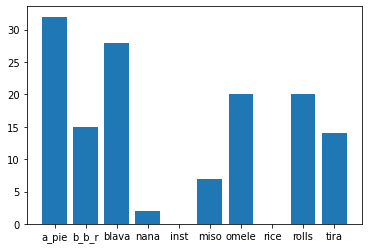

In [10]:
# compilation of all erorr
print("Wrong Prediction")
for i in range(len(check)):
  print(labels[i])
  print("wrong predictions: ",check[i],"/",total[i])
  print("Accuracy:",((total[i]-check[i])/total[i])*100,"%")
 
labeling = ["a_pie","b_b_r","blava","nana","inst","miso","omele","rice","rolls","tira"]
plt.bar(labeling,check)
plt.show()

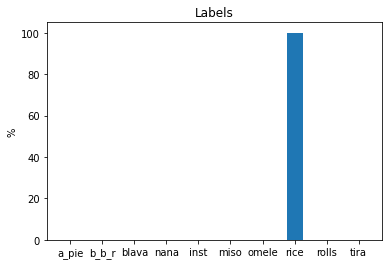

In [11]:
# show the predictions of each labels
from google.colab.patches import cv2_imshow
y_pos=[0,10,20,30,40,50,60,70,80,90]
# {0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'instant_noodle', 4: 'miso_soup', 5: 'omelette', 6: 'spring_rolls', 7: 'tiramisu'}
labeling = ["a_pie","b_b_r","blava","nana","inst","miso","omele","rice","rolls","tira"]
performance=np.abs(pred[676]*100)
#print(performance)
plot1=plt.figure(1)
plt.bar(y_pos, performance, align='center', alpha=1,width=5)
#plt.xticks(y_pos,test_generator.class_indices)
plt.xticks(y_pos,labeling)
plt.ylabel('%')
plt.title('Labels')
plt.show()  

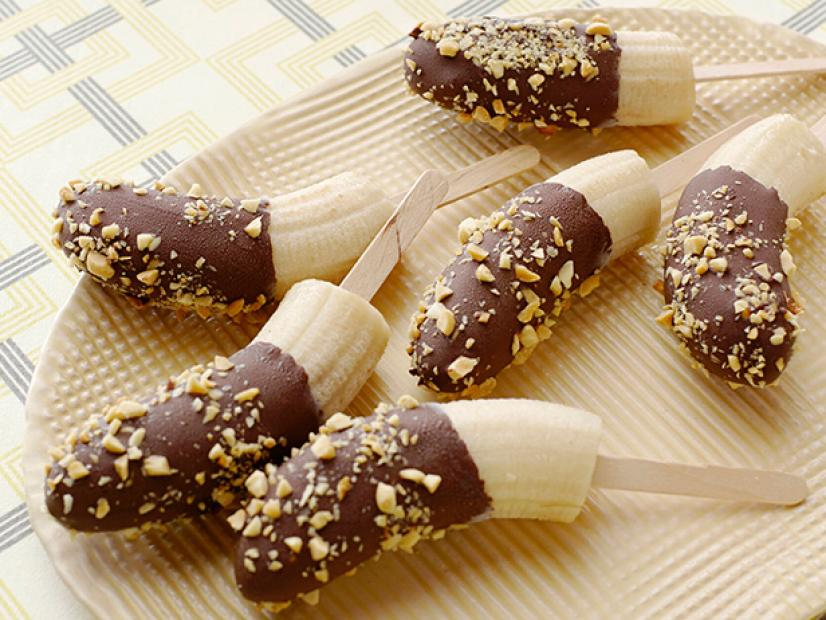

In [ ]:
# to see what kind of pictures are in the dataset
from google.colab.patches import cv2_imshow
import cv2
loc=r"./dataset/test/"+test_generator.filenames[384]
img = cv2.imread(loc) 
cv2_imshow(img)
